MJO packages  
https://mdtf-diagnostics.readthedocs.io/en/latest/sphinx_pods/MJO_suite.html  
https://github.com/NOAA-GFDL/MDTF-diagnostics/tree/main/diagnostics/MJO_prop_amp

## Load pre-computed data?

In [1]:
LOAD = False
data_dir = '/vortexfs1/scratch/kcarr/era-interim'

In [2]:
import os
from os.path import join
import xarray as xr
from eofs.xarray import Eof
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from multiprocessing import Pool
from matplotlib.colors import ListedColormap
from matplotlib.collections import LineCollection
from collections import Counter
import cartopy.crs as ccrs
from copy import deepcopy

# Add directory to path
import sys
sys.path.append('/vortexfs1/home/kcarr/summer-project-2020/') 
import utils
from utils import stack_month_and_year, unstack_month_and_year, get_proj_xr
from preprocess import remove_season, get_trend_fast

# Function to detrend
def prep(x):
    '''Function removes trend and seasonal cycle from xarray variable'''
    y = x - get_trend_fast(x)
    y = y.groupby('time.month') - y.groupby('time.month').mean()
    return y

def prep_mjo_data(x):
    '''Function to pre-process data associated with the MJO
    Specifically: 1. remove linear relationship with ENSO
                  2. remove 120 day running mean
                  3. average over latitudes, and normalize by global variance'''
    print( 'Removing linear relationship with ENSO...')
    x_mjo = x - get_proj_xr(oni_daily, x) # remove relationship with ENSO
    print('Removing 120-day running mean...')
    x_mjo = x_mjo.isel(time=slice(119,None)) - \
        x_mjo.rolling(time=120).mean().isel(time=slice(119,None)) # 120-day mean
    x_mjo = x_mjo.mean(dim='latitude')
    x_mjo = x_mjo / x_mjo.std()
    return x_mjo

def get_mjo_phase(x, y):
    '''Function to get the phase of the MJO, based on first two PCs from Wheeler/Hendon index'''
    mag = np.sqrt(x**2 + y**2)
    if mag < 1: # only classify if magnitude is greater than 1
        return -1
    else:
        if x>=0:
            if y>=0:
                return 5. if np.abs(x)>=np.abs(y) else 6
            else:
                return 4 if np.abs(x)>=np.abs(y) else 3
        else:
            if y>=0:
                return 8 if np.abs(x)>=np.abs(y) else 7
            else:
                return 1 if np.abs(x)>=np.abs(y) else 2
            return
        return
    return

def get_mjo_phase_(data):
    '''Helper function: takes single argument, allowing us to pass it to np.apply_along_axis'''
    x,y = data
    return get_mjo_phase(x,y)

cdo


# Pre-process data (or load pre-computed data)

In [3]:
if LOAD:
    print('Loading pre-computed data')
    ##### Read in de-trended and de-seasonalized data
    oni = xr.open_dataarray(os.path.join(data_dir, 'oni.nc'))
    oni_daily = xr.open_dataarray(os.path.join(data_dir, 'oni_daily.nc'))
    olr = xr.open_dataarray(os.path.join(data_dir, 'olr_prep.nc'))
    u = xr.open_dataarray(os.path.join(data_dir, 'u_prep.nc'))
    v = xr.open_dataarray(os.path.join(data_dir, 'v_prep.nc'))
    tp = xr.open_dataarray(os.path.join(data_dir, 'tp_prep.nc'))
    tp_us = xr.open_dataarray(os.path.join(data_dir, 'tp_us_prep.nc'))
    mjo_data = xr.open_dataarray(os.path.join(data_dir, 'mjo_data.nc'))

else:
    print('Pre-processing data')
    # read in raw data
    sst = xr.open_dataset(join(data_dir, 'sst.mon.mean.nc')).sst
    olr = xr.open_dataset(join(data_dir, 'ttr_daily.nc')).ttr
    olr = -olr / (12*3600) # convert units from J/m^2 to W/m^2, and flip sign
    u = xr.open_dataset(join(data_dir, 'u_daily.nc')).u
    v = xr.open_dataset(join(data_dir, 'v_daily.nc')).v
    tp = xr.open_dataset(join(data_dir, 'tp_daily.nc')).tp
    tp_us = xr.open_dataset(join(data_dir, 'tp_us_daily.nc')).tp
    tp_us = tp_us * 1000*2*30 # convert from m/[12-hr] to mm/month

    # compute ONI anomalies (ENSO index)
    sst = sst - get_trend_fast(sst)
    sst = remove_season(sst, standardize=False)[0]
    oni = sst.mean(dim=['longitude','latitude']).rolling(time=3).mean()
    # interpolate to daily
    oni_daily = oni.interp(time=pd.date_range('1979-01-01', '2017-12-02', freq='D'))
    
    # MAKE SURE TIMES MATCH
    oni_daily = oni_daily.isel(time=slice(None,-1)) # Get rid of extra time step
    olr = olr.isel(time=slice(None,-1))
    tp = tp.isel(time=slice(None,-1))
    tp_us = tp_us.isel(time=slice(None,-1))
    olr['time'] = oni_daily.time # set times equal
    tp['time'] = oni_daily.time
    u['time'] = oni_daily.time
    v['time'] = oni_daily.time
    tp_us['time'] = oni_daily.time
    oni_daily = oni_daily.isel(time=slice(60,None)) # Remove first 60 time steps
    u = u.isel(time=slice(60,None))
    v = v.isel(time=slice(60,None))
    tp = tp.isel(time=slice(60,None))
    olr = olr.isel(time=slice(60,None))
    tp = tp.isel(time=slice(60,None))
    tp_us = tp_us.isel(time=slice(60,None))
    
    # remove trend and seasonal cycle from atmospheric data
    res = []
    for d in[olr, u, v, tp, tp_us]:
        res.append(prep(d))

    # unpack results    
    olr, u, v, tp, tp_us = res
    
    # prep MJO data (i.e. remove ENSO, average over latitudes, divide by global var)
    u200_mjo = prep_mjo_data(u.sel(level=200).drop('level'))
    u850_mjo = prep_mjo_data(u.sel(level=850).drop('level'))
    olr_mjo = prep_mjo_data(olr)
    mjo_data = xr.concat([u200_mjo, u850_mjo, olr_mjo],
                         dim=pd.Index(['u200','u850','olr'], name='variable'))
    mjo_data = mjo_data.transpose('time',...)
    mjo_data = mjo_data - mjo_data.mean (dim='time') # make sure data is centered at 0

    ##### SAVE RESULTS
    oni.to_netcdf(os.path.join(data_dir, 'oni.nc'))
    oni_daily.to_netcdf(os.path.join(data_dir, 'oni_daily.nc'))
    olr.to_netcdf(os.path.join(data_dir, 'olr_prep.nc'))
    u.to_netcdf(os.path.join(data_dir, 'u_prep.nc'))
    v.to_netcdf(os.path.join(data_dir, 'v_prep.nc'))
    tp.to_netcdf(os.path.join(data_dir, 'tp_prep.nc'))
    tp_us.to_netcdf(os.path.join(data_dir, 'tp_us_prep.nc'))
    mjo_data.to_netcdf(os.path.join(data_dir, 'mjo_data.nc'))
    
# mask precipitation data
lsm = xr.open_dataset(join(data_dir, 'invariants.nc')).lsm.squeeze('time', drop='True')
lsm =lsm.interp(latitude=tp_us.latitude, longitude=tp_us.longitude)
cutoff=.3
lsm.values[lsm < cutoff] = 0.
lsm.values[lsm >= cutoff] = 1.
tp_us = tp_us * lsm

Pre-processing data


/vortexfs1/home/kcarr/.conda/envs/torch_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/vortexfs1/home/kcarr/.conda/envs/torch_env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Removing linear relationship with ENSO...
Removing 120-day running mean...
Removing linear relationship with ENSO...
Removing 120-day running mean...
Removing linear relationship with ENSO...
Removing 120-day running mean...


# EOFs

In [20]:
eof_obj = Eof(mjo_data) #### EOF analysis to get MJO index

# Get 1st two principal components (used to identify MJO phase)
rmm = eof_obj.pcs(pcscaling=1, npcs=2)
eofs = eof_obj.eofs(eofscaling=2, neofs=2)

# Reverse signs to match Wheeler-Hendon paper
rmm = -rmm
eofs = -eofs

# select first two modes for MJO index
rmm1 = rmm.sel(mode=0)
rmm2 = rmm.sel(mode=1)

# check reconstruction
res2 = np.einsum('ab,bcd->acd', eof_obj.pcs(pcscaling=1), eof_obj.eofs(eofscaling=2)).reshape(mjo_data.shape)
print(np.allclose(mjo_data, res2))

##### Determine MJO phases ######
mjo_phase = np.nan * deepcopy(rmm1)
mjo_phase.values = np.apply_along_axis(func1d=get_mjo_phase_, 
                                       arr=np.stack([rmm1.values,rmm2.values],axis=1), 
                                       axis=1)

True


# Plots

### Leading EOFs and explained variance

Need to flip EOFs and PCs for $u$ wind components

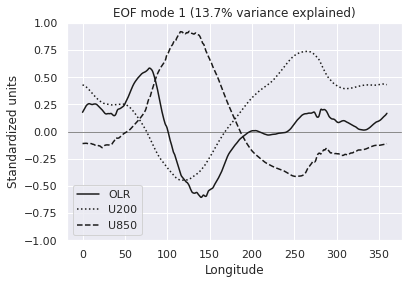

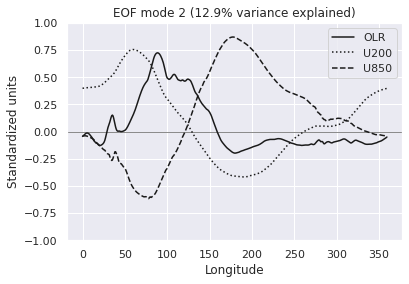

In [26]:
####### Plot the two dominant EOFs (corresponding to the RMM index)
for mode in [0,1]:
    fig,ax=plt.subplots()
    ax.plot(eofs.longitude, eofs.sel(mode=mode, variable='olr'), label='OLR', color='k')
    ax.plot(eofs.longitude, eofs.sel(mode=mode, variable='u200'), label='U200', color='k', linestyle=':')
    ax.plot(eofs.longitude, eofs.sel(mode=mode, variable='u850'), label='U850', color='k', linestyle='--')
    ax.axhline(y=0,color='k', linewidth=.5)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Standardized units')
    ax.set_ylim([-1,1])
    v1 = eof_obj.varianceFraction(neigs=2).values[mode].item()
    ax.set_title(f'EOF mode {mode+1} ({100*v1:.1f}% variance explained)')
    ax.legend()
    plt.show()

## MJO phase composites

#### OLR/U composite

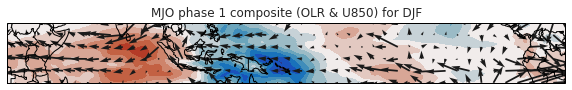

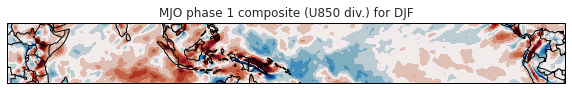

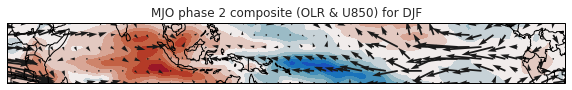

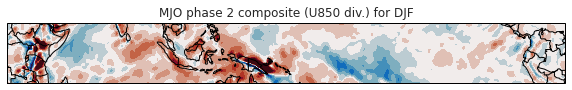

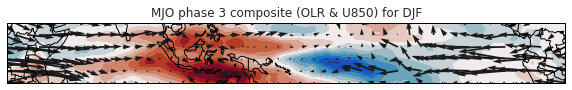

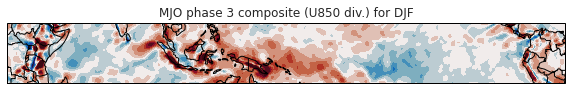

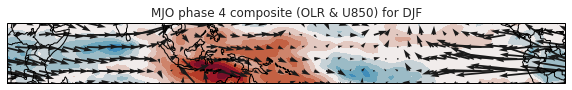

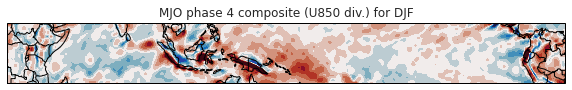

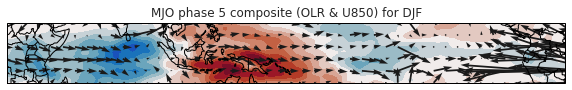

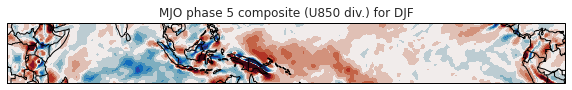

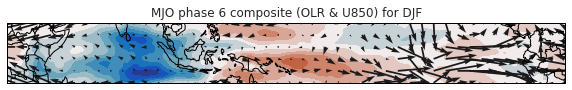

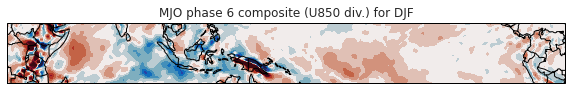

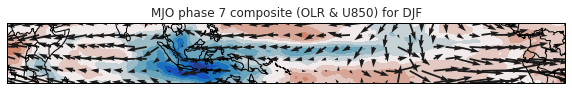

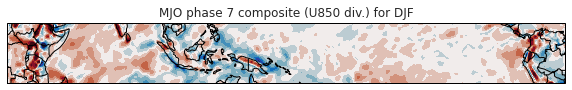

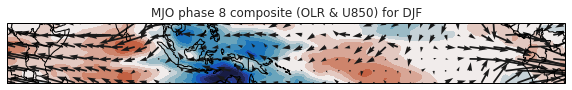

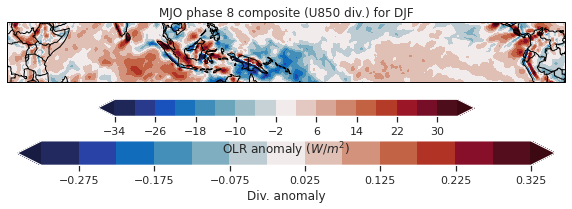

In [12]:
DJF = True # only plot composite for DJF months?
lev = 850 # one of {200,850}
u_x = u.differentiate(coord='longitude') # divergence

n=8 # plot every nth vector in the plots
for phase in np.arange(1,9): # do for each of the 8 phases
    d = mjo_phase[mjo_phase==phase].time
    if DJF: # get DJF months
        d = d[(d.dt.month == 12) | (d.dt.month == 1) | (d.dt.month == 2)] 
    phase_composite = olr.sel(time=d).mean(dim='time') # get OLR composite
    div_composite = u_x.sel(time=d).mean(dim='time')
    
    # U850 winds
    u_composite = u.sel(time=d, level=lev).mean(dim='time')
    v_composite = v.sel(time=d, level=lev).mean(dim='time')
    fig, ax = utils.plot_setup(plot_range=[20,300,-15,15],
                               central_lon=180,figsize=(10,3))
    ax.set_title(f'MJO phase {phase} composite (OLR & U{lev}) for DJF')
    cp = ax.contourf(phase_composite.longitude, phase_composite.latitude, 
                     phase_composite, cmap='cmo.balance', extend='both', 
                     transform=ccrs.PlateCarree(), levels=np.arange(-34,38,4))
    qv = ax.quiver(u.longitude.values[::n], # plot wind
                   u.latitude.values[::n],
                   u_composite[::n,::n],
                   v_composite[::n,::n])
    plt.show()
    
    fig, ax = utils.plot_setup(plot_range=[20,300,-15,15],
                               central_lon=180,figsize=(10,3))
    ax.set_title(f'MJO phase {phase} composite (U{lev} div.) for DJF')
    cp2 = ax.contourf(div_composite.longitude, div_composite.latitude, 
                     div_composite.sel(level=lev), cmap='cmo.balance', extend='both', 
                     transform=ccrs.PlateCarree(), levels=np.arange(-.325,.375,.05))
#     cb2 = fig.colorbar(cp2, orientation='horizontal', label=r'Div anomaly ($W/m^2$)')
    
    if phase==8:
        cb2 = fig.colorbar(cp2, orientation='horizontal', label=r'Div. anomaly')
        cb = fig.colorbar(cp, orientation='horizontal', label=r'OLR anomaly ($W/m^2$)')
    plt.show()

### plot sample of MJO phase

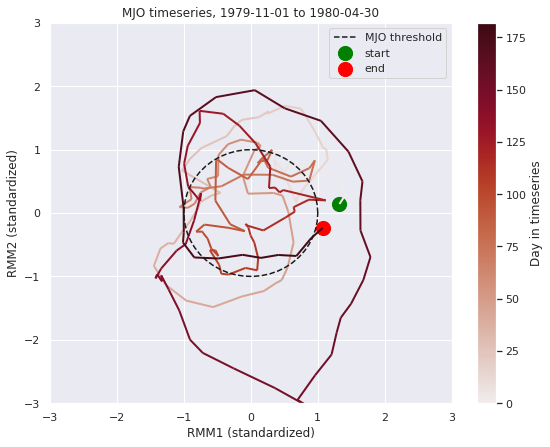

In [7]:
theta = np.linspace(0,2*np.pi)
x0 = np.cos(theta)
y0 = np.sin(theta)
year = 1979
d1 = f'{year}-11-01'
d2 = f'{year+1}-04-30'
x = rmm1.sel(time=slice(d1,d2))
y = rmm2.sel(time=slice(d1,d2))

fig,ax = plt.subplots(figsize=(9,7))
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
norm = plt.Normalize(0, len(x))
lc = LineCollection(segments, cmap='cmo.amp', norm=norm)
lc.set_array(np.arange(len(x)))
lc.set_linewidth(2)
line = ax.add_collection(lc)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
ax.scatter(x[0],y[0],marker='o', s=200, label='start', color='green')
ax.scatter(x[-1],y[-1],marker='o', s=200, label='end', color='red')
ax.plot(x0,y0, linestyle='--', color='k', label='MJO threshold')
ax.set_xlabel('RMM1 (standardized)')
ax.set_ylabel('RMM2 (standardized)')
ax.set_title('MJO timeseries, 1979-11-01 to 1980-04-30')
ax.legend()
fig.colorbar(line, label='Day in timeseries')
plt.show()

### Distribution of MJO over months

In [8]:
phase_counts   = Counter(mjo_phase[mjo_phase>0].values)
monthly_counts = Counter(mjo_phase[mjo_phase>0].time.dt.month.values)

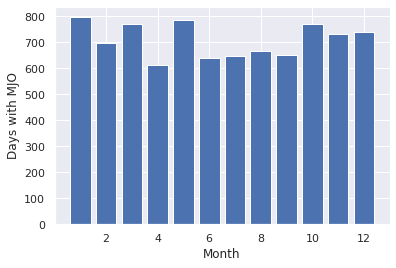

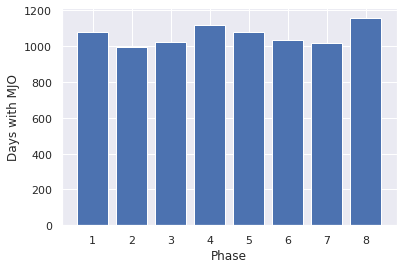

In [9]:
fig,ax = plt.subplots()
ax.bar(monthly_counts.keys(), monthly_counts.values())
ax.set_xlabel('Month')
ax.set_ylabel('Days with MJO')
plt.show()

fig,ax = plt.subplots()
ax.bar(phase_counts.keys(), phase_counts.values())
ax.set_xlabel('Phase')
ax.set_ylabel('Days with MJO')
plt.show()

### MJO composite for precipitation

Use significance testing!!!!!!!!  
estimate mean and standard error for the estimate (std dev divided by M^2)  
how to create standardized plots (divide by standard error? or standard deviation?)  
compare to 0 (using standard hypothesis test and monte carlo)  

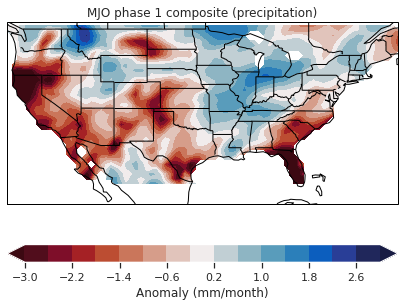

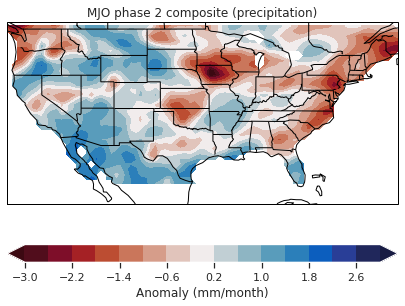

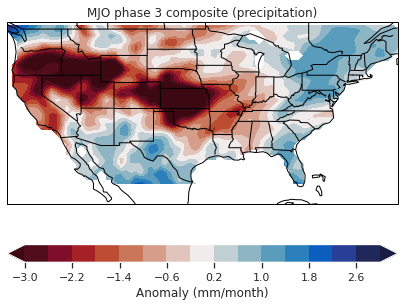

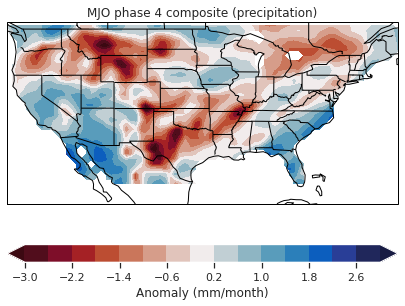

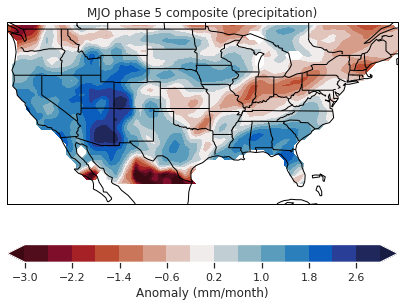

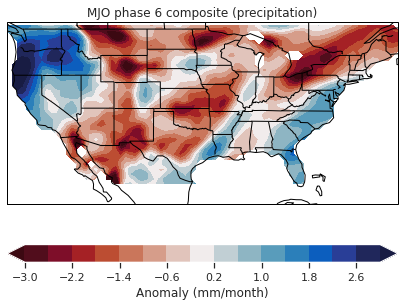

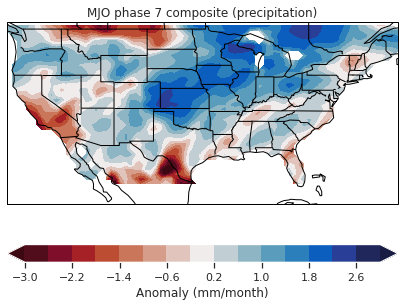

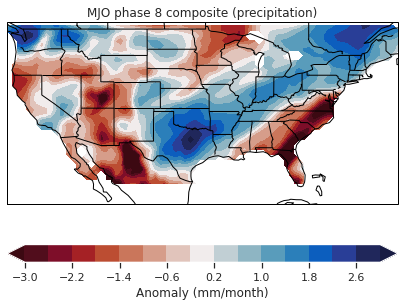

In [78]:
for phase in range(1,9):
    d = mjo_phase[mjo_phase==phase].time
    d = d[(d.dt.month == 12) | (d.dt.month == 1) | (d.dt.month == 2)]
    M = len(d.time)
    phase_composite = tp_us.sel(time=d).mean(dim='time')
    phase_composite_stderr = tp_us.sel(time=d).std(dim='time') / np.sqrt(M)
    
#     fig,ax = utils.plot_setup()
#     cp = ax.contourf(phase_composite.longitude, phase_composite.latitude, 
#                      phase_composite, cmap='cmo.balance_r',
#                     levels=np.linspace(-24,24,12), extend='both')
#     if phase==8:
#         cb = fig.colorbar(cp, orientation='horizontal', label='Anomaly (mm/month)')
#     ax.set_title(f'MJO phase {phase} composite (precipitation)')
#     plt.show()
    
#     fig,ax = utils.plot_setup()
#     cp = ax.contourf(phase_composite.longitude, phase_composite.latitude, 
#                      phase_composite_std, cmap='cmo.amp',
#                     levels=10, extend='both')
#     cb = fig.colorbar(cp, orientation='horizontal', label='variance')
#     ax.set_title(f'MJO phase {phase} variance')
#     plt.show()
    fig,ax = utils.plot_setup()
    cp = ax.contourf(phase_composite.longitude, phase_composite.latitude, 
                     phase_composite/phase_composite_stderr, cmap='cmo.balance_r',
                    levels=np.arange(-3.0,3.4,.4), extend='both')
    cb = fig.colorbar(cp, orientation='horizontal', label='Anomaly (mm/month)')
    ax.set_title(f'MJO phase {phase} composite (precipitation)')
    plt.show()

# Precipitation clustering / ENSO analysis

### Identify precipitation regions

In [9]:
print('clustering')
prect_ = prect.stack(posn=['lat','lon'])

idx = np.where(~np.isnan(prect_.isel(time=0)).values)[0]
vals = prect_.isel(posn=idx).values

from sklearn.cluster import KMeans
from copy import deepcopy

# Fit kmeans
model = KMeans(n_clusters=9)
model.fit(vals.T)

# Get labels
labels = np.nan*deepcopy(prect_.isel(time=0, drop=True))
labels[idx] = model.labels_
labels = labels.unstack()

k_vals = np.unique(labels.values)
k_vals = k_vals[~np.isnan(k_vals)]

cluster_mask = xr.concat([labels for _ in range(len(k_vals))], dim='cluster').assign_coords({'cluster':k_vals})
for i,c in enumerate(cluster_mask.cluster.values):
    cluster_mask.values[i,:] = 1. * cluster_mask.values[i,:]==c

cluster_mask.values[cluster_mask.values==0] = np.nan    

clustering


**Plot clusters**

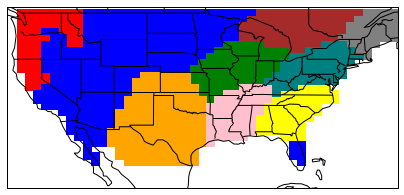

In [10]:
def plot_clusters(labels, colors, plot_range=[-125.25, -66, 22.5, 50]):
    '''Function plots clusters on map'''
    x,y = np.meshgrid(labels.lon.values, labels.lat.values)
    k_vals = np.unique(labels.values)
    k_vals = k_vals[~np.isnan(k_vals)]
    fig, ax = utils.plot_setup()
    for i, k in enumerate(k_vals):
        color = ListedColormap(colors[i])
        mask = (labels.values==k)*1.
        mask[mask==0] = np.nan
        ax.pcolormesh(x,y,mask, cmap=color)
    return fig, ax

colors = ['red','blue','green','orange','pink','yellow', 'brown', 'gray', 'teal']
fig, ax = plot_clusters(labels, colors = colors)

## Composite of El-Nino events

In [8]:
nino_days = oni_daily[oni_daily > oni_daily.std()].time
nina_days = oni_daily[oni_daily < -oni_daily.std()].time

In [9]:
nino_composite = prect.sel(time=nino_days).mean(dim='time')
nina_composite = prect.sel(time=nina_days).mean(dim='time')

/vortexfs1/home/kcarr/.conda/envs/torch_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


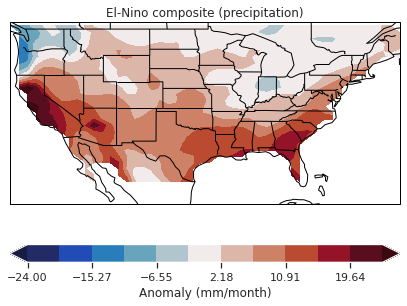

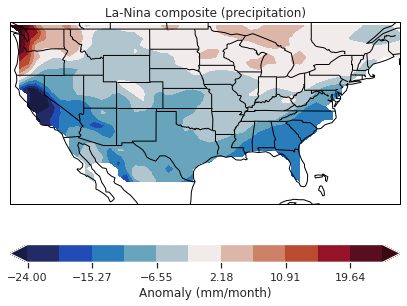

In [10]:
a = 1000*3600*24*365/12 # conversion factor from m/s to mm/month

fig,ax = utils.plot_setup()
cp = ax.contourf(nino_composite.lon, nino_composite.lat, a*nino_composite, cmap='cmo.balance',
                levels=np.linspace(-24,24,12), extend='both')
cb = fig.colorbar(cp, orientation='horizontal', label='Anomaly (mm/month)')
ax.set_title(r'El-Nino composite (precipitation)')
plt.show()

fig,ax = utils.plot_setup()
cp = ax.contourf(nina_composite.lon, nina_composite.lat, a*nina_composite, cmap='cmo.balance',
                levels=np.linspace(-24,24,12), extend='both')
cb = fig.colorbar(cp, orientation='horizontal', label='Anomaly (mm/month)')
ax.set_title(r'La-Nina composite (precipitation)')
plt.show()

#### ONI timeseries

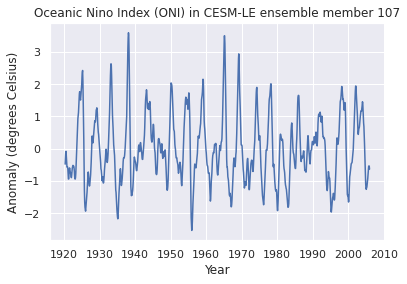

In [5]:
## plot ONI index
fig,ax = plt.subplots()
ax.plot(oni.time, oni)
ax.set_xlabel('Year')
ax.set_ylabel('Anomaly (degrees Celsius)')
ax.set_title('Oceanic Nino Index (ONI) in CESM-LE ensemble member 107')
plt.show()

# Analysis
- power spectrum (ENSO RMM components, and precip)
- linear regression
- neural net
- stochastic model (?)

#### RMM lagged correlation

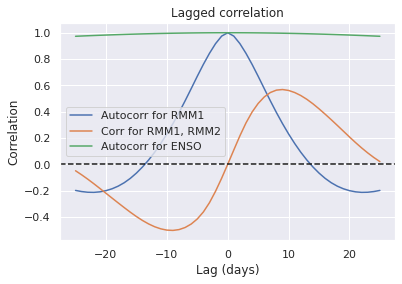

Correlation with ENSO
RMM1: 0.022
RMM2: 0.109


In [11]:
def get_rho(x1, x2):
    '''Function to get correlation coefficient for 2 timeseries'''
    x = np.stack([x1,x2], axis=1)
    cov = (x.T @ x) / (len(x)-1)
    rho = cov[0,1] / np.prod(np.sqrt(np.diag(cov)))
    return rho
def get_lagged_autocorr(x, lags=np.arange(1,26)):
    '''Get lagged autocorrelation for time series, and reflect about t=0'''
    rho = []
    for lag in lags:
        x1 = x[:-lag]
        x2 = x[lag:]
        rho.append(get_rho(x1,x2))
    rho = list(reversed(rho))+ [1.] + rho # reflect about y-axis
    return rho
def get_lagged_corr(x1, x2, lags=np.arange(-25,26)):
    '''Get lagged correlation for two time series'''
    rho = []
    for lag in lags:
        if lag==0:
            y1 = x1
            y2 = x2
        elif lag<0:
            y1 = x1[-lag:]
            y2 = x2[:lag]
        else:
            y1 = x1[:-lag]
            y2 = x2[lag:]
        rho.append(get_rho(y1,y2))
    return rho

rmm1_rho = get_lagged_autocorr(rmm1)
rmm2_rho = get_lagged_autocorr(rmm2)
rmm1_rmm2_rho = get_lagged_corr(rmm1,rmm2)
enso_rho = get_lagged_autocorr(oni_daily)
    
# Lagged correlation plots
fig,ax = plt.subplots()
ax.plot(np.arange(-25,26), rmm1_rho, label = r'Autocorr for RMM1')
# ax.plot(np.arange(-25,26), rmm2_rho, label = r'Autocorr for RMM2')
ax.plot(np.arange(-25,26), rmm1_rmm2_rho, label = r'Corr for RMM1, RMM2')
ax.plot(np.arange(-25,26), enso_rho, label = r'Autocorr for ENSO')
ax.axhline(y=0, linestyle='--', color='k')
ax.set_xlabel('Lag (days)')
ax.set_ylabel('Correlation')
ax.set_title('Lagged correlation')
ax.legend()
plt.show()

print('Correlation with ENSO')
print(f'RMM1: {get_rho(rmm1, oni_daily.sel(time=slice("1979-06-29",None))):.3f}')
print(f'RMM2: {get_rho(rmm2, oni_daily.sel(time=slice("1979-06-29",None))):.3f}')

# Predict precipitation at 2, 4, and 6 week intervals
#### Get coefficients for linear regression

Get error estimates for coefficients (?)

In [6]:
# Get two-week rolling average for precipitation
y = tp_us.isel(time=slice(119,None)) # match times to MJO data
y = y.rolling(time=14).mean().isel(time=slice(13,None)) # Get rolling 2-week mean
oni_ = oni_daily.isel(time=slice(119,None)).isel(time=slice(None,-13))
oni_ = prep(oni_) / oni_.std()
y['time'] = oni_['time'] # change date for rolling mean so that date is the START of the 2-week period
E = xr.concat([rmm1.isel(time=slice(None,-13)).drop(['month', 'mode']), 
               rmm2.isel(time=slice(None,-13)).drop(['month', 'mode']), 
               oni_], 
               dim=pd.Index(['rmm1','rmm2','oni'], name='variable'))
y = y.stack(n=['latitude','longitude']).transpose('time',...)
E = E.transpose('time',...)

n_train = int(.75 * len(E.time))
sep = 365 # number of days between end of train set and start of test set
E_train = E.isel(time=slice(None,n_train-sep))
E_test = E.isel(time=slice(n_train,None))
y_train = y.isel(time=slice(None,n_train-sep))
y_test = y.isel(time=slice(n_train,None))

# coefficients for predicting weeks 3 & 4
x_34 = utils.get_coef(E_train.isel(time=slice(None,-14)).values,
                      y_train.isel(time=slice(14, None)).values)

# coefficients for predicting weeks 5 & 6
x_56 = utils.get_coef(E_train.isel(time=slice(None,-28)).values,
                      y_train.isel(time=slice(28, None)).values)

#### Make predictions and evaluate

In [89]:
# regression predictions
model_pred34 = utils.get_fit(x_34, E_test.isel(time=slice(None,-14)))
model_pred56 = utils.get_fit(x_56, E_test.isel(time=slice(None,-28)))

# climatology predictions: predict mean value for all weeks (i.e., zero)
clim_pred34 = np.zeros_like(pred_weeks34)
clim_pred56 = np.zeros_like(pred_weeks56)

# persistence predictions: use past two weeks of rainfall to predict weeks 3/4 and 5/6
per_pred34 = y_test.isel(time=slice(None,-14)).values
per_pred56 = y_test.isel(time=slice(None,-28)).values

# Evaluate: compare to actual values
def mse(y, y0, by_loc=True):
    '''Compute mean square error
    if by_loc is True, compute MSE for each location separately'''
    axis = 0 if by_loc else None
    return np.mean((y-y0)**2, axis=axis)

mses = dict()
mses['model_34'] = mse(y_test.isel(time=slice(14, None)).values, model_pred34)
mses['clim_34']  = mse(y_test.isel(time=slice(14, None)).values, clim_pred34)
mses['per_34']   = mse(y_test.isel(time=slice(14, None)).values, per_pred34)

mses['model_56'] = mse(y_test.isel(time=slice(28, None)).values, model_pred56)
mses['clim_56']  = mse(y_test.isel(time=slice(28, None)).values, clim_pred56)
mses['per_56']   = mse(y_test.isel(time=slice(28, None)).values, per_pred56)

mses['model_34_total'] = mse(y_test.isel(time=slice(14, None)).values, model_pred34, by_loc=False)
mses['clim_34_total']  = mse(y_test.isel(time=slice(14, None)).values, clim_pred34, by_loc=False)
mses['per_34_total']   = mse(y_test.isel(time=slice(14, None)).values, per_pred34, by_loc=False)

mses['model_56_total'] = mse(y_test.isel(time=slice(28, None)).values, model_pred56, by_loc=False)
mses['clim_56_total']  = mse(y_test.isel(time=slice(28, None)).values, clim_pred56, by_loc=False)
mses['per_56_total']   = mse(y_test.isel(time=slice(28, None)).values, per_pred56, by_loc=False)

In [100]:
mses['model_34_total']

1531.8311791891927

May need to standardize precipitation by standard deviation...

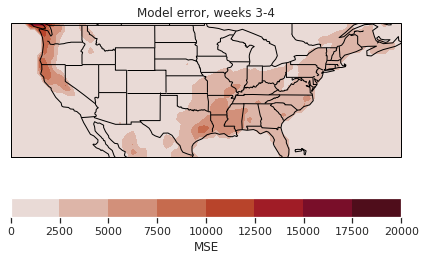

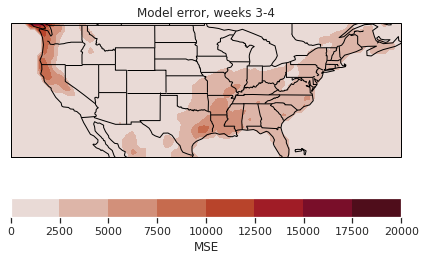

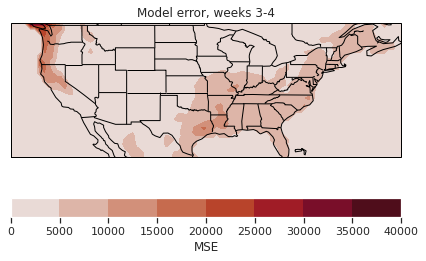

In [53]:
lon = y_test.n.unstack('n').longitude
lat = y_test.n.unstack('n').latitude
fig,ax = utils.plot_setup(plot_range = [lon[0],lon[-1],lat[0],lat[-1]])
cp = ax.contourf(lon, lat, mses['model_34'].reshape(len(lat), len(lon)),
                cmap='cmo.amp')
ax.set_title('Model error, weeks 3-4')
cb = fig.colorbar(cp, orientation='horizontal', label='MSE')
plt.show()


fig,ax = utils.plot_setup(plot_range = [lon[0],lon[-1],lat[0],lat[-1]])
cp = ax.contourf(lon, lat, mses['clim_34'].reshape(len(lat), len(lon)),
                cmap='cmo.amp')
ax.set_title('Model error, weeks 3-4')
cb = fig.colorbar(cp, orientation='horizontal', label='MSE')
plt.show()

fig,ax = utils.plot_setup(plot_range = [lon[0],lon[-1],lat[0],lat[-1]])
cp = ax.contourf(lon, lat, mses['per_34'].reshape(len(lat), len(lon)),
                cmap='cmo.amp')
ax.set_title('Model error, weeks 3-4')
cb = fig.colorbar(cp, orientation='horizontal', label='MSE')
plt.show()

Plot improvement over each  
Predict temperature instead of precipitation?  
Add significance!!

/vortexfs1/home/kcarr/.conda/envs/torch_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


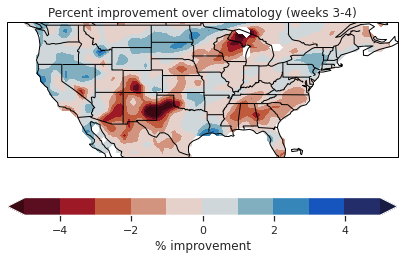

/vortexfs1/home/kcarr/.conda/envs/torch_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


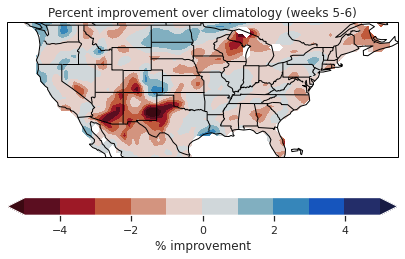

/vortexfs1/home/kcarr/.conda/envs/torch_env/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


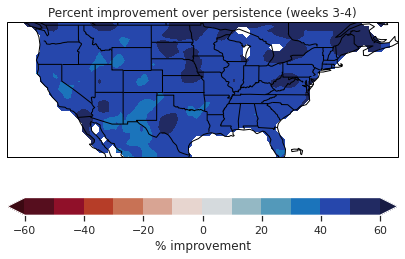

/vortexfs1/home/kcarr/.conda/envs/torch_env/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


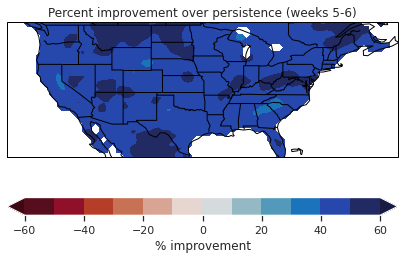

In [67]:
fig,ax = utils.plot_setup(plot_range = [lon[0],lon[-1],lat[0],lat[-1]])
cp = ax.contourf(lon, lat, 
                 100*((mses['clim_34'] - mses['model_34']) / mses['clim_34']).reshape(len(lat), len(lon)),
                cmap='cmo.balance_r', levels=np.arange(-5,6,1), extend='both')
ax.set_title('Percent improvement over climatology (weeks 3-4)')
cb = fig.colorbar(cp, orientation='horizontal', label='% improvement')
plt.show()

fig,ax = utils.plot_setup(plot_range = [lon[0],lon[-1],lat[0],lat[-1]])
cp = ax.contourf(lon, lat, 
                 100*((mses['clim_56'] - mses['model_56']) / mses['clim_56']).reshape(len(lat), len(lon)),
                cmap='cmo.balance_r', levels=np.arange(-5,6,1), extend='both')
ax.set_title('Percent improvement over climatology (weeks 5-6)')
cb = fig.colorbar(cp, orientation='horizontal', label='% improvement')
plt.show()

fig,ax = utils.plot_setup(plot_range = [lon[0],lon[-1],lat[0],lat[-1]])
cp = ax.contourf(lon, lat, 
                 100*((mses['per_34'] - mses['model_34']) / mses['per_34']).reshape(len(lat), len(lon)),
                cmap='cmo.balance_r', levels=np.arange(-60,61,10), extend='both')
ax.set_title('Percent improvement over persistence (weeks 3-4)')
cb = fig.colorbar(cp, orientation='horizontal', label='% improvement')
plt.show()

fig,ax = utils.plot_setup(plot_range = [lon[0],lon[-1],lat[0],lat[-1]])
cp = ax.contourf(lon, lat, 
                 100*((mses['per_56'] - mses['model_56']) / mses['per_56']).reshape(len(lat), len(lon)),
                cmap='cmo.balance_r', levels=np.arange(-60,61,10), extend='both')
ax.set_title('Percent improvement over persistence (weeks 5-6)')
cb = fig.colorbar(cp, orientation='horizontal', label='% improvement')
plt.show()

Plot coefficient associated with each variable for every location

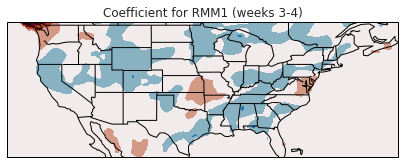

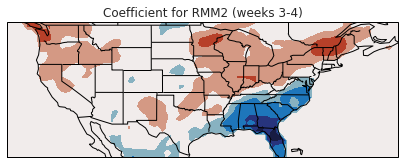

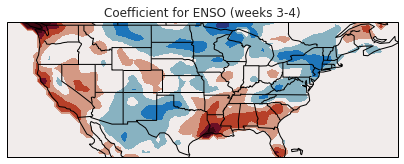

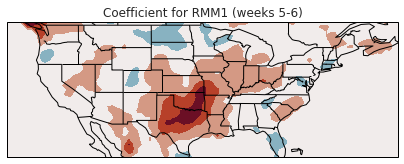

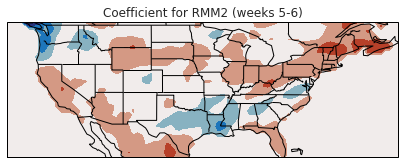

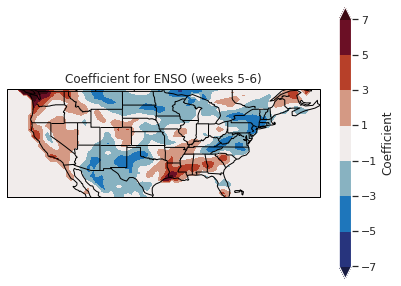

In [88]:
fig,ax = utils.plot_setup(plot_range = [lon[0],lon[-1],lat[0],lat[-1]])
cp = ax.contourf(lon, lat, x_34[0,:].reshape(len(lat),len(lon)),
                cmap='cmo.balance', levels=np.arange(-7,9,2), extend='both')
ax.set_title('Coefficient for RMM1 (weeks 3-4)')
# cb = fig.colorbar(cp, orientation='horizontal', label='Coefficient')
plt.show()

fig,ax = utils.plot_setup(plot_range = [lon[0],lon[-1],lat[0],lat[-1]])
cp = ax.contourf(lon, lat, x_34[1,:].reshape(len(lat),len(lon)),
                cmap='cmo.balance', levels=np.arange(-7,9,2), extend='both')
ax.set_title('Coefficient for RMM2 (weeks 3-4)')
# cb = fig.colorbar(cp, orientation='horizontal', label='Coefficient')
plt.show()

fig,ax = utils.plot_setup(plot_range = [lon[0],lon[-1],lat[0],lat[-1]])
cp = ax.contourf(lon, lat, x_34[2,:].reshape(len(lat),len(lon)),
                cmap='cmo.balance', levels=np.arange(-7,9,2), extend='both')
ax.set_title('Coefficient for ENSO (weeks 3-4)')
# cb = fig.colorbar(cp, orientation='horizontal', label='Coefficient')
plt.show()

fig,ax = utils.plot_setup(plot_range = [lon[0],lon[-1],lat[0],lat[-1]])
cp = ax.contourf(lon, lat, x_56[0,:].reshape(len(lat),len(lon)),
                cmap='cmo.balance', levels=np.arange(-7,9,2), extend='both')
ax.set_title('Coefficient for RMM1 (weeks 5-6)')
# cb = fig.colorbar(cp, orientation='horizontal', label='Coefficient')
plt.show()

fig,ax = utils.plot_setup(plot_range = [lon[0],lon[-1],lat[0],lat[-1]])
cp = ax.contourf(lon, lat, x_56[1,:].reshape(len(lat),len(lon)),
                cmap='cmo.balance', levels=np.arange(-7,9,2), extend='both')
ax.set_title('Coefficient for RMM2 (weeks 5-6)')
# cb = fig.colorbar(cp, orientation='horizontal', label='Coefficient')
plt.show()

fig,ax = utils.plot_setup(plot_range = [lon[0],lon[-1],lat[0],lat[-1]])
cp = ax.contourf(lon, lat, x_56[2,:].reshape(len(lat),len(lon)),
                cmap='cmo.balance', levels=np.arange(-7,9,2), extend='both')
ax.set_title('Coefficient for ENSO (weeks 5-6)')
cb = fig.colorbar(cp, orientation='vertical', label='Coefficient')
plt.show()

Can linear model predict MJO? I.e. can it capture the periodic behavior